In [ ]:
import warnings
warnings.filterwarnings('ignore')

# Load FICO HELOC data with special values converted to np.nan
from aix360.datasets.heloc_dataset import HELOCDataset, nan_preprocessing
data = HELOCDataset(custom_preprocessing=nan_preprocessing).data()
# Separate target variable
y = data.pop('RiskPerformance')

# Split data into training and test sets using fixed random seed
from sklearn.model_selection import train_test_split
dfTrain, dfTest, yTrain, yTest = train_test_split(data, y, random_state=0, stratify=y)
dfTrain.head().transpose()

In [2]:
# Binarize data and also return standardized ordinal features
from aix360.algorithms.rbm import FeatureBinarizer
fb = FeatureBinarizer(negations=True, returnOrd=True)
dfTrain, dfTrainStd = fb.fit_transform(dfTrain)
dfTest, dfTestStd = fb.transform(dfTest)
dfTrain['ExternalRiskEstimate'].head()

operation   <=                                            >                 \
value     59.0 63.0 66.0 69.0 72.0 75.0 78.0 82.0 86.0 59.0 63.0 66.0 69.0   
8960         0    0    1    1    1    1    1    1    1    1    1    0    0   
8403         1    1    1    1    1    1    1    1    1    0    0    0    0   
1949         1    1    1    1    1    1    1    1    1    0    0    0    0   
4886         0    0    1    1    1    1    1    1    1    1    1    0    0   
4998         0    0    1    1    1    1    1    1    1    1    1    0    0   

operation                           ==  !=  
value     72.0 75.0 78.0 82.0 86.0 NaN NaN  
8960         0    0    0    0    0   0   1  
8403         0    0    0    0    0   0   1  
1949         0    0    0    0    0   0   1  
4886         0    0    0    0    0   0   1  
4998         0    0    0    0    0   0   1

### Import statements

Import necessary libraries, frameworks and algorithms.

In [20]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import tensorflow as tf
from keras.models import Sequential, Model, load_model, model_from_json
from keras.layers import Dense
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML

from aix360.algorithms.contrastive import CEMExplainer, KerasClassifier
from aix360.algorithms.protodash import ProtodashExplainer
from aix360.datasets.heloc_dataset import HELOCDataset

### Load HELOC dataset and show sample applicants

In [21]:
heloc = HELOCDataset()
df = heloc.dataframe()
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 24)
pd.set_option('display.width', 1000)
print("Size of HELOC dataset:", df.shape)
print("Number of \"Good\" applicants:", np.sum(df['RiskPerformance']=='Good'))
print("Number of \"Bad\" applicants:", np.sum(df['RiskPerformance']=='Bad'))
print("Sample Applicants:")
df.head(10).transpose()

Using Heloc dataset:  c:\users\ronnyluss\aix360\aix360\datasets\..\data\heloc_data\heloc_dataset.csv
Size of HELOC dataset: (10459, 24)
Number of "Good" applicants: 5000
Number of "Bad" applicants: 5459
Sample Applicants:


,0,1,2,3,4,5,6,7,8,9
ExternalRiskEstimate,55,61,67,66,81,59,54,68,59,61
MSinceOldestTradeOpen,144,58,66,169,333,137,88,148,324,79
MSinceMostRecentTradeOpen,4,15,5,1,27,11,7,7,2,4
AverageMInFile,84,41,24,73,132,78,37,65,138,36
NumSatisfactoryTrades,20,2,9,28,12,31,25,17,24,19
NumTrades60Ever2DerogPubRec,3,4,0,1,0,0,0,0,0,0
NumTrades90Ever2DerogPubRec,0,4,0,1,0,0,0,0,0,0
PercentTradesNeverDelq,83,100,100,93,100,91,92,83,85,95
MSinceMostRecentDelq,2,-7,-7,76,-7,1,9,31,5,5
MaxDelq2PublicRecLast12M,3,0,7,6,7,4,4,6,4,4


Distribution of ExternalRiskEstimate and NumSatisfactoryTrades columns:


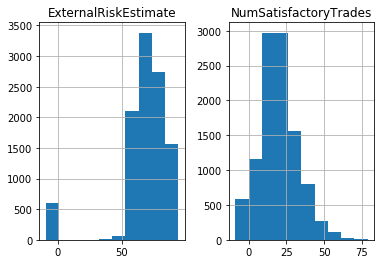

In [22]:
# Plot (example) distributions for two features
print("Distribution of ExternalRiskEstimate and NumSatisfactoryTrades columns:")
hist = df.hist(column=['ExternalRiskEstimate', 'NumSatisfactoryTrades'], bins=10)

#### a. Process the dataset

In [23]:
# Clean data and split dataset into train/test
(Data, x_train, x_test, y_train_b, y_test_b) = heloc.split()

## Question 4

In [ ]:
import lime
import lime.lime_tabular

Z = np.vstack((x_train, x_test))
Zmax = np.max(Z, axis=0)
Zmin = np.min(Z, axis=0)

#normalize an array of samples to range [-0.5, 0.5]
def normalize(V):
    VN = (V - Zmin)/(Zmax - Zmin)
    VN = VN - 0.5
    return(VN)
    
# rescale a sample to recover original values for normalized values. 
def rescale(X):
    return(np.multiply ( X + 0.5, (Zmax - Zmin) ) + Zmin)

N = normalize(Z)
xn_train = N[0:x_train.shape[0], :]
xn_test  = N[x_train.shape[0]:, :]
def nn_small():
    model = Sequential()
    model.add(Dense(10, input_dim=23, kernel_initializer='normal', activation='relu'))
    model.add(Dense(2, kernel_initializer='normal'))    
    return model  
# Set random seeds for repeatability
np.random.seed(1) 
tf.set_random_seed(2) 

class_names = ['Bad', 'Good']

# loss function
def fn(correct, predicted):
    return tf.nn.softmax_cross_entropy_with_logits(labels=correct, logits=predicted)

# compile and print model summary
nn = nn_small()
nn.compile(loss=fn, optimizer='adam', metrics=['accuracy'])
nn.summary()


# train model or load a trained model
TRAIN_MODEL = True

if (TRAIN_MODEL): 
    nn.fit(xn_train, y_train_b, batch_size=128, epochs=500, verbose=1, shuffle=False)
    nn.save_weights("heloc_nnsmall.h5")     
else:    
    nn.load_weights("heloc_nnsmall.h5")
        

# evaluate model accuracy        
score = nn.evaluate(xn_train, y_train_b, verbose=0) #Compute training set accuracy
print('Train accuracy:', score[1])

score = nn.evaluate(xn_test, y_test_b, verbose=0) #Compute test set accuracy
print('Test accuracy:', score[1])

columns = list(dfTrain.columns)
explainer = lime.lime_tabular.LimeTabularExplainer(xn_train, feature_names=columns, class_names=['RiskPerformance'], discretize_continuous=True)
exp = explainer.explain_instance(xn_test[1], nn.predict_proba, top_labels=1)

# Show explanation
exp.show_in_notebook(show_table=True, show_all=True)

In [27]:
p_train = nn.predict_classes(xn_train) # Use trained neural network to predict train points
p_train = p_train.reshape((p_train.shape[0],1))

z_train = np.hstack((xn_train, p_train)) # Store (normalized) instances that were predicted as Good
z_train_good = z_train[z_train[:,-1]==1, :]

zun_train = np.hstack((x_train, p_train)) # Store (unnormalized) instances that were predicted as Good 
zun_train_good = zun_train[zun_train[:,-1]==1, :]

## Question 2

In [ ]:
idx = 3 

X = xn_test[idx].reshape((1,) + xn_test[idx].shape)

print("Chosen Sample:", idx)
print("Prediction made by the model:", class_names[np.argmax(nn.predict_proba(X))])
print("Prediction probabilities:", nn.predict_proba(X))
print("")

# attach the prediction made by the model to X
X = np.hstack((X, nn.predict_classes(X).reshape((1,1))))

Xun = x_test[idx].reshape((1,) + x_test[idx].shape) 
dfx = pd.DataFrame.from_records(Xun.astype('double')) # Create dataframe with original feature values
dfx[23] = class_names[int(X[0, -1])]
dfx.columns = df.columns
dfx.transpose()

explainer = ProtodashExplainer()
(W, S, setValues) = explainer.explain(X, z_train_good, m=5) # Return weights W, Prototypes S and objective function values

dfs = pd.DataFrame.from_records(zun_train_good[S, 0:-1].astype('double'))
RP=[]
for i in range(S.shape[0]):
    RP.append(class_names[int(z_train_good[S[i], -1])]) # Append class names
dfs[23] = RP
dfs.columns = df.columns  
dfs["Weight"] = np.around(W, 5)/np.sum(np.around(W, 5)) # Calculate normalized importance weights
dfs.transpose()

z = z_train_good[S, 0:-1] # Store chosen prototypes
eps = 1e-10 # Small constant defined to eliminate divide-by-zero errors
fwt = np.zeros(z.shape)
for i in range (z.shape[0]):
    for j in range(z.shape[1]):
        fwt[i, j] = np.exp(-1 * abs(X[0, j] - z[i,j])/(np.std(z[:, j])+eps)) # Compute feature similarity in [0,1]
                
# move wts to a dataframe to display
dfw = pd.DataFrame.from_records(np.around(fwt.astype('double'), 2))
dfw.columns = df.columns[:-1]
dfw.transpose()        

## Question 3

In [ ]:
import warnings
warnings.filterwarnings('ignore')

heloc = HELOCDataset()
df = heloc.dataframe()
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 24)
pd.set_option('display.width', 1000)
print("Size of HELOC dataset:", df.shape)
print("Number of \"Good\" applicants:", np.sum(df['RiskPerformance']=='Good'))
print("Number of \"Bad\" applicants:", np.sum(df['RiskPerformance']=='Bad'))
print("Sample Applicants:")
df.head(10).transpose()

In [ ]:
# Clean data and split dataset into train/test
PROCESS_DATA = False

if (PROCESS_DATA): 
    (Data, x_train, x_test, y_train_b, y_test_b) = heloc.split()
    np.savez('heloc.npz', Data=Data, x_train=x_train, x_test=x_test, y_train_b=y_train_b, y_test_b=y_test_b)
else:
    heloc = np.load('heloc.npz', allow_pickle = True)
    Data = heloc['Data']
    x_train = heloc['x_train']
    x_test  = heloc['x_test']
    y_train_b = heloc['y_train_b']
    y_test_b  = heloc['y_test_b']

In [ ]:
Z = np.vstack((x_train, x_test))
Zmax = np.max(Z, axis=0)
Zmin = np.min(Z, axis=0)

#normalize an array of samples to range [-0.5, 0.5]
def normalize(V):
    VN = (V - Zmin)/(Zmax - Zmin)
    VN = VN - 0.5
    return(VN)
    
# rescale a sample to recover original values for normalized values. 
def rescale(X):
    return(np.multiply ( X + 0.5, (Zmax - Zmin) ) + Zmin)

N = normalize(Z)
xn_train = N[0:x_train.shape[0], :]
xn_test  = N[x_train.shape[0]:, :]

In [ ]:
# nn with no softmax
def nn_small():
    model = Sequential()
    model.add(Dense(10, input_dim=23, kernel_initializer='normal', activation='relu'))
    model.add(Dense(2, kernel_initializer='normal'))    
    return model    

# Set random seeds for repeatability
np.random.seed(1) 
tf.set_random_seed(2) 

class_names = ['Bad', 'Good']

# loss function
def fn(correct, predicted):
    return tf.nn.softmax_cross_entropy_with_logits(labels=correct, logits=predicted)

# compile and print model summary
nn = nn_small()
nn.compile(loss=fn, optimizer='adam', metrics=['accuracy'])
nn.summary()


# train model or load a trained model
TRAIN_MODEL = False

if (TRAIN_MODEL):             
    nn.fit(xn_train, y_train_b, batch_size=128, epochs=500, verbose=1, shuffle=False)
    nn.save_weights("heloc_nnsmall.h5")     
else:    
    nn.load_weights("heloc_nnsmall.h5")
        

# evaluate model accuracy        
score = nn.evaluate(xn_train, y_train_b, verbose=0) #Compute training set accuracy
#print('Train loss:', score[0])
print('Train accuracy:', score[1])

score = nn.evaluate(xn_test, y_test_b, verbose=0) #Compute test set accuracy
#print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [ ]:
idx = 2344

X = xn_test[idx].reshape((1,) + xn_test[idx].shape)
print("Computing PN for Sample:", idx)
print("Prediction made by the model:", nn.predict_proba(X))
print("Prediction probabilities:", class_names[np.argmax(nn.predict_proba(X))])
print("")

mymodel = KerasClassifier(nn)
explainer = CEMExplainer(mymodel)

arg_mode = 'PN' # Find pertinent negatives
arg_max_iter = 1000 # Maximum number of iterations to search for the optimal PN for given parameter settings
arg_init_const = 10.0 # Initial coefficient value for main loss term that encourages class change
arg_b = 9 # No. of updates to the coefficient of the main loss term
arg_kappa = 0.2 # Minimum confidence gap between the PNs (changed) class probability and original class' probability
arg_beta = 1e-1 # Controls sparsity of the solution (L1 loss)
arg_gamma = 100 # Controls how much to adhere to a (optionally trained) auto-encoder
my_AE_model = None # Pointer to an auto-encoder
arg_alpha = 0.01 # Penalizes L2 norm of the solution
arg_threshold = 1. # Automatically turn off features <= arg_threshold if arg_threshold < 1
arg_offset = 0.5 # the model assumes classifier trained on data normalized
                # in [-arg_offset, arg_offset] range, where arg_offset is 0 or 0.5
# Find PN for applicant 1272
(adv_pn, delta_pn, info_pn) = explainer.explain_instance(X, arg_mode, my_AE_model, arg_kappa, arg_b,
                                                         arg_max_iter, arg_init_const, arg_beta, arg_gamma,
                                                            arg_alpha, arg_threshold, arg_offset)

In [ ]:
Xpn = adv_pn
classes = [ class_names[np.argmax(nn.predict_proba(X))], class_names[np.argmax(nn.predict_proba(Xpn))], 'NIL' ]

print("Sample:", idx)
print("prediction(X)", nn.predict_proba(X), class_names[np.argmax(nn.predict_proba(X))])
print("prediction(Xpn)", nn.predict_proba(Xpn), class_names[np.argmax(nn.predict_proba(Xpn))] )


X_re = rescale(X) # Convert values back to original scale from normalized
Xpn_re = rescale(Xpn)
Xpn_re = np.around(Xpn_re.astype(np.double), 2)

delta_re = Xpn_re - X_re
delta_re = np.around(delta_re.astype(np.double), 2)
delta_re[np.absolute(delta_re) < 1e-4] = 0

X3 = np.vstack((X_re, Xpn_re, delta_re))

dfre = pd.DataFrame.from_records(X3) # Create dataframe to display original point, PN and difference (delta)
dfre[23] = classes

dfre.columns = df.columns
dfre.rename(index={0:'X',1:'X_PN', 2:'(X_PN - X)'}, inplace=True)
dfret = dfre.transpose()


def highlight_ce(s, col, ncols):
    if (type(s[col]) != str):
        if (s[col] > 0):
            return(['background-color: yellow']*ncols)    
    return(['background-color: white']*ncols)

dfret.style.apply(highlight_ce, col='(X_PN - X)', ncols=3, axis=1) 

In [ ]:
plt.rcdefaults()
fi = abs((X-Xpn).astype('double'))/np.std(xn_train.astype('double'), axis=0) # Compute PN feature importance
objects = df.columns[-2::-1]
y_pos = np.arange(len(objects))
performance = fi[0, -1::-1]

plt.barh(y_pos, performance, align='center', alpha=0.5) # bar chart
plt.yticks(y_pos, objects) # Display features on y-axis
plt.xlabel('weight') # x-label
plt.title('PN (feature importance)') # Heading

plt.show() # Display PN feature importance

In [ ]:
idx = 449

X = xn_test[idx].reshape((1,) + xn_test[idx].shape)
print("Computing PN for Sample:", idx)
print("Prediction made by the model:", nn.predict_proba(X))
print("Prediction probabilities:", class_names[np.argmax(nn.predict_proba(X))])
print("")

mymodel = KerasClassifier(nn)
explainer = CEMExplainer(mymodel)

arg_mode = 'PN' # Find pertinent negatives
arg_max_iter = 1000 # Maximum number of iterations to search for the optimal PN for given parameter settings
arg_init_const = 10.0 # Initial coefficient value for main loss term that encourages class change
arg_b = 9 # No. of updates to the coefficient of the main loss term
arg_kappa = 0.2 # Minimum confidence gap between the PNs (changed) class probability and original class' probability
arg_beta = 1e-1 # Controls sparsity of the solution (L1 loss)
arg_gamma = 100 # Controls how much to adhere to a (optionally trained) auto-encoder
my_AE_model = None # Pointer to an auto-encoder
arg_alpha = 0.01 # Penalizes L2 norm of the solution
arg_threshold = 1. # Automatically turn off features <= arg_threshold if arg_threshold < 1
arg_offset = 0.5 # the model assumes classifier trained on data normalized
                # in [-arg_offset, arg_offset] range, where arg_offset is 0 or 0.5
# Find PN for applicant 1272
(adv_pn, delta_pn, info_pn) = explainer.explain_instance(X, arg_mode, my_AE_model, arg_kappa, arg_b,
                                                         arg_max_iter, arg_init_const, arg_beta, arg_gamma,
                                                            arg_alpha, arg_threshold, arg_offset)

In [ ]:
Xpn = adv_pn
classes = [ class_names[np.argmax(nn.predict_proba(X))], class_names[np.argmax(nn.predict_proba(Xpn))], 'NIL' ]

print("Sample:", idx)
print("prediction(X)", nn.predict_proba(X), class_names[np.argmax(nn.predict_proba(X))])
print("prediction(Xpn)", nn.predict_proba(Xpn), class_names[np.argmax(nn.predict_proba(Xpn))] )


X_re = rescale(X) # Convert values back to original scale from normalized
Xpn_re = rescale(Xpn)
Xpn_re = np.around(Xpn_re.astype(np.double), 2)

delta_re = Xpn_re - X_re
delta_re = np.around(delta_re.astype(np.double), 2)
delta_re[np.absolute(delta_re) < 1e-4] = 0

X3 = np.vstack((X_re, Xpn_re, delta_re))

dfre = pd.DataFrame.from_records(X3) # Create dataframe to display original point, PN and difference (delta)
dfre[23] = classes

dfre.columns = df.columns
dfre.rename(index={0:'X',1:'X_PN', 2:'(X_PN - X)'}, inplace=True)
dfret = dfre.transpose()


def highlight_ce(s, col, ncols):
    if (type(s[col]) != str):
        if (s[col] > 0):
            return(['background-color: yellow']*ncols)    
    return(['background-color: white']*ncols)

dfret.style.apply(highlight_ce, col='(X_PN - X)', ncols=3, axis=1) 

In [ ]:
plt.rcdefaults()
fi = abs((X-Xpn).astype('double'))/np.std(xn_train.astype('double'), axis=0) # Compute PN feature importance
objects = df.columns[-2::-1]
y_pos = np.arange(len(objects))
performance = fi[0, -1::-1]

plt.barh(y_pos, performance, align='center', alpha=0.5) # bar chart
plt.yticks(y_pos, objects) # Display features on y-axis
plt.xlabel('weight') # x-label
plt.title('PN (feature importance)') # Heading

plt.show() # Display PN feature importance

In [ ]:
idx = 1168

X = xn_test[idx].reshape((1,) + xn_test[idx].shape)
print("Computing PN for Sample:", idx)
print("Prediction made by the model:", nn.predict_proba(X))
print("Prediction probabilities:", class_names[np.argmax(nn.predict_proba(X))])
print("")

mymodel = KerasClassifier(nn)
explainer = CEMExplainer(mymodel)

arg_mode = 'PN' # Find pertinent negatives
arg_max_iter = 1000 # Maximum number of iterations to search for the optimal PN for given parameter settings
arg_init_const = 10.0 # Initial coefficient value for main loss term that encourages class change
arg_b = 9 # No. of updates to the coefficient of the main loss term
arg_kappa = 0.2 # Minimum confidence gap between the PNs (changed) class probability and original class' probability
arg_beta = 1e-1 # Controls sparsity of the solution (L1 loss)
arg_gamma = 100 # Controls how much to adhere to a (optionally trained) auto-encoder
my_AE_model = None # Pointer to an auto-encoder
arg_alpha = 0.01 # Penalizes L2 norm of the solution
arg_threshold = 1. # Automatically turn off features <= arg_threshold if arg_threshold < 1
arg_offset = 0.5 # the model assumes classifier trained on data normalized
                # in [-arg_offset, arg_offset] range, where arg_offset is 0 or 0.5
# Find PN for applicant 1272
(adv_pn, delta_pn, info_pn) = explainer.explain_instance(X, arg_mode, my_AE_model, arg_kappa, arg_b,
                                                         arg_max_iter, arg_init_const, arg_beta, arg_gamma,
                                                            arg_alpha, arg_threshold, arg_offset)

In [ ]:
Xpn = adv_pn
classes = [ class_names[np.argmax(nn.predict_proba(X))], class_names[np.argmax(nn.predict_proba(Xpn))], 'NIL' ]

print("Sample:", idx)
print("prediction(X)", nn.predict_proba(X), class_names[np.argmax(nn.predict_proba(X))])
print("prediction(Xpn)", nn.predict_proba(Xpn), class_names[np.argmax(nn.predict_proba(Xpn))] )


X_re = rescale(X) # Convert values back to original scale from normalized
Xpn_re = rescale(Xpn)
Xpn_re = np.around(Xpn_re.astype(np.double), 2)

delta_re = Xpn_re - X_re
delta_re = np.around(delta_re.astype(np.double), 2)
delta_re[np.absolute(delta_re) < 1e-4] = 0

X3 = np.vstack((X_re, Xpn_re, delta_re))

dfre = pd.DataFrame.from_records(X3) # Create dataframe to display original point, PN and difference (delta)
dfre[23] = classes

dfre.columns = df.columns
dfre.rename(index={0:'X',1:'X_PN', 2:'(X_PN - X)'}, inplace=True)
dfret = dfre.transpose()


def highlight_ce(s, col, ncols):
    if (type(s[col]) != str):
        if (s[col] > 0):
            return(['background-color: yellow']*ncols)    
    return(['background-color: white']*ncols)

dfret.style.apply(highlight_ce, col='(X_PN - X)', ncols=3, axis=1) 

In [ ]:
plt.rcdefaults()
fi = abs((X-Xpn).astype('double'))/np.std(xn_train.astype('double'), axis=0) # Compute PN feature importance
objects = df.columns[-2::-1]
y_pos = np.arange(len(objects))
performance = fi[0, -1::-1]

plt.barh(y_pos, performance, align='center', alpha=0.5) # bar chart
plt.yticks(y_pos, objects) # Display features on y-axis
plt.xlabel('weight') # x-label
plt.title('PN (feature importance)') # Heading

plt.show() # Display PN feature importance